<a href="https://colab.research.google.com/github/astrfo/RS-CH/blob/main/RS_CH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS-CH 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://github.com/astrfo/AutonomousOptimalExplorationThroughSatisficing/blob/main/AutonomousOptimalExplorationThroughSatisficing.ipynb




In [214]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [215]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [216]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy, param, K):
        if 'RS-CH' == policy:
            self.act_policy = self.RS_CH
            self.aleph = param
            self.RS = np.zeros(K)
        if 'RS-OPT' == policy:
            self.act_policy = self.RS_OPT
            self.aleph = param
            self.RS = np.zeros(K)
        if 'e-greedy' == policy:
            self.act_policy = self.e_greedy
            self.epsilon = param
        if 'random' == policy:
            self.act_policy = self.random_
        if 'TS' == policy:
            self.act_policy = self.ThompsonSampling
            self._a = np.ones(K)
            self._b = np.ones(K)

    def D_KL(self, p, q):
        return p*np.log(p/q) + (1-p)*np.log( (1-p) / (1-q) )

    def RS_CH(self, V, n, N, *args):
        G = random.choice(np.where(V == V.max())[0])        # greedyな腕
        self.RS = (n / (N+1)) * (V - self.aleph)        # RS評価値の更新
        RSG = (n[G] / (N+1)) * (V[G] - self.aleph)     # RS[G]の全ての j に対して
        mu = np.exp(-n * self.D_KL(V, V[G]))        # μ^CHの計算 (24)
        mu[G] = 0.0
        self.aleph = V[G] * (1 - (V/V[G]) * mu) / (1 - mu)      # R^CHの計算 (25)
        np.nan_to_num(self.aleph, copy=False, nan=0)
        exceed_RSG_index = np.where(RSG <= self.RS)[0]     # RS[G]以上のindexを取り出す

        if len(exceed_RSG_index) == 1:     # RS[G]が最も高い
            arm = G
        else:
            if len(np.where(RSG < self.RS)[0]) == 1:     # RS[G] < RS[j]
                arm = np.where(RSG < self.RS)[0][0]
            else:
                exceed_mu = mu[exceed_RSG_index]
                max_mu_index = np.where(exceed_mu.max() == exceed_mu)[0]
                if len(max_mu_index) == 1:      # 最も高いμが1つだった場合はその腕を選択
                    arm = exceed_RSG_index[max_mu_index[0]]
                else:                                                        # 最も高いμが２つ以上だった場合
                    exceed_aleph = self.aleph[max_mu_index]
                    max_aleph_index = np.where(exceed_aleph.max() == exceed_aleph)[0]
                    if len(max_aleph_index) == 1:     # 最も高いalephが1つだった場合はその腕を選択
                        arm = exceed_RSG_index[max_mu_index[max_aleph_index[0]]]
                    else:                                                           # 最も高いalephが2つ以上だった場合はランダムに選択
                        arm = np.random.choice(exceed_RSG_index[max_mu_index[max_aleph_index]])
        return arm

    def RS_OPT(self, V, n, N, *args):
        self.RS = (n / (N+1)) * (V - self.aleph)
        return np.random.choice(np.where(self.RS == self.RS.max())[0])

    def e_greedy(self, V, *args):
        if self.epsilon < np.random.rand():
            return np.random.choice(np.where(V == V.max())[0])
        else:
            return np.random.randint(len(V))

    def random_(self, V, *args):
        return np.random.randint(len(V))


    def ThompsonSampling(self, V, n, N, r, selected_arm):
        theta = np.array([np.random.beta(self._a[i]+1, self._b[i]+1) for i in range(len(self._a))])
        # print(f'a: {self._a}, b: {self._b}')
        if r == 1: self._a[selected_arm] += 1
        else: self._b[selected_arm] += 1
        arm = np.random.choice(np.where(theta == theta.max())[0])
        return arm

In [217]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    選択肢を選ぶ
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.policy = None
        self._r = None

    def initialize(self, policy, param):
        self.policy = Policy(policy, param, self._K)        # RS評価値, aleph等の初期化
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self._r = 0                                       # TSのパラメータ
        self._a = 0

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self._r = reward
        self._a = arm

    def select_arm(self):
        return self.policy.act_policy(self._V, self._n, self._N, self._r, self._a)

In [218]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        # self._algorithm = {"TS": np.array([0.0] * K)}
        self._algorithm = {"RS-CH": np.array([1.0] * K), "TS": np.array([0.0] * K)}
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros(step)
        self._regretV = None
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo, param in self._algorithm.items():
            self._agent = RSAgent(self._K)
            print(f'algorithm: {algo}, param: {param}')
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                if algo == 'RS-OPT': self._agent.policy.aleph = sum(sorted(self._prob, reverse=True)[:2]) / 2
                self._agent.initialize(algo, param)
                self._regretV = 0.0
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regretV += (self._prob.max() - self._prob[arm])
        self._regret[s] += (self._regretV - self._regret[s]) / (t+1)

    def print_regret(self):
        self.ax.plot(np.arange(self._step), self._regret, linestyle='dashed')
        self.ax.set_title(f'sim: {self._trial}, step: {self._step}, K: {self._K}')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm.keys())

algorithm: RS-CH, param: [1. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


KeyboardInterrupt: ignored

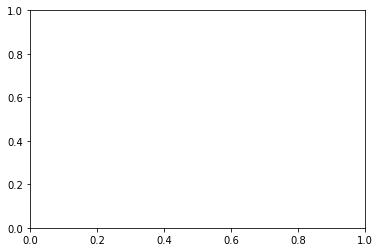

In [219]:
def main():
    trial = 10
    step = 1000000
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()



start = time.time()
main()
elapsed_time = time.time() - start
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")